In [1]:
import glob
import shutil
import SimpleITK as sitk
import numpy as np
import os
from collections import Counter
from multiprocessing import Pool
from numpy.lib.npyio import save
from numpy.lib.shape_base import _dstack_dispatcher
from numpy.lib.type_check import imag
from pathlib import Path
import pathlib
import multiprocessing
import math
import functools
from functools import partial
from Utils import *

import pydicom
import re
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
#上面是一个搜索标注信息的demo，可以自动扫描设定文件夹下的目录
'''这里顺便记录一下整体的数据描述信息，
1. /data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/3-1marked1/文件目录下的文件，基本上都是病人号文件夹下，影像文件有dcm序列，标注文件一般都是.nii的后缀,也有nii.gz
2. /data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/resistant+non-sensitizing/ 下基本存储的也是病人号文件夹下，影像文件有dcm序列，标注文件一般都是.nii的后缀，部分文件是nii.gz文件
可能需要做一定部分特殊处理
3./data/wyh_data/影像数据EGFR1第二部分/primary_new/EGFR-negative/下的数据一般是以nii.gz作为文件影像信息，数据文件一般是.nii的后缀，标注信息大部分是名称中带有mask的nii文件，注意，标注文件不只一个
'''
#这是基本上所有有标注信息的概览，文件中具有大量的无标签信息，或许是无监督/自监督的点

In [2]:
file_path='/home/wyh21/AI_Lung_node/sample_data/0017565058'

In [3]:



# 获取该文件下的所有序列ID，每个序列对应一个ID， 返回的series_IDs为一个列表
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(file_path)

# 查看该文件夹下的序列数量
nb_series = len(series_IDs)
print(nb_series)

# 通过ID获取该ID对应的序列所有切片的完整路径， series_IDs[0]代表的是第一个序列的ID
# 如果不添加series_IDs[0]这个参数，则默认获取第一个序列的所有切片路径
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(file_path, series_IDs[0])

# # 新建一个ImageSeriesReader对象
# series_reader = sitk.ImageSeriesReader()

# # 通过之前获取到的序列的切片路径来读取该序列
# series_reader.SetFileNames(series_file_names)

# # 获取该序列对应的3D图像
# image3D = series_reader.Execute()

# # 查看该3D图像的尺寸
# print(image3D.GetSize())

# # 将序列保存为单个的NRRD文件
# sitk.WriteImage(image3D, 'img3D.nrrd')


8


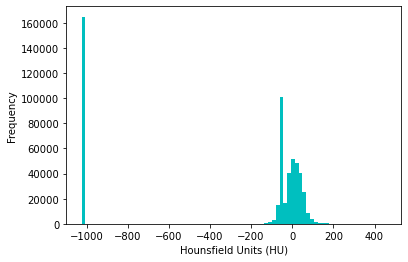

IndexError: index 80 is out of bounds for axis 0 with size 2

In [4]:
first_patient = load_scan(list(series_file_names))
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [29]:
series_file_names

('/home/wyh21/AI_Lung_node/sample_data/0017565058/1.3.12.2.1107.5.1.4.66043.30000016122623264509000016821.dcm',
 '/home/wyh21/AI_Lung_node/sample_data/0017565058/1.3.12.2.1107.5.1.4.66043.30000016122623264509000016957.dcm')

In [4]:
file_list=get_file(data_path)

In [9]:
import SimpleITK as sitk
import numpy as np
# img_path='F:\\dataset\\pancreas\\Output\\thick\\original\\1'
# mask_path='F:\\dataset\\pancreas\\Output\\thick\\groundtruth\\1'
 
reader = sitk.ImageSeriesReader()
img_names = reader.GetGDCMSeriesFileNames(data_path)
reader.SetFileNames(img_names)
image = reader.Execute()
image_array = sitk.GetArrayFromImage(image) # z, y, x
 
# reader = sitk.ImageSeriesReader()
# mask_names = reader.GetGDCMSeriesFileNames(mask_path)
# reader.SetFileNames(mask_names)
# mask = reader.Execute()
# mask_array = sitk.GetArrayFromImage(mask) # z, y, x

In [26]:
bupt='/data/wyh_data/影像数据EGFR1第二部分/Marked/POSITIVE/3-1marked1/3-1marked1/0017604420/'

file_reader = sitk.ImageSeriesReader()
img_names = reader.GetGDCMSeriesFileNames(bupt)
series_IDs = reader.GetGDCMSeriesIDs(bupt)
#reader.SetFileNames(img_names)
# image = reader.Execute()
# image_array = sitk.GetArrayFromImage(image) # z, y, x
file_reader = sitk.ImageFileReader()
for series in series_IDs:
        series_file_names =  reader.GetGDCMSeriesFileNames(bupt, series)
        # 根据一个单张的dcm文件，读取这个series的metedata，即可以获取这个序列的描述符
        file_reader.SetFileName(series_file_names[0])
        file_reader.ReadImageInformation()
        series_description = file_reader.GetMetaData("0008|103e") # 序列的描述符，为CT WB 5.0 B31f、PET WB (AC)和ThorRoutine 2.0 B40f
        dicom_itk = sitk.ReadImage(series_file_names)
        print(dicom_itk)

Image (0x556dc9db6e20)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 30965
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 30822
  UpdateMTime: 30964
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 2]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 2]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 2]
  Spacing: [2, 2, 1]
  Origin: [-511, -149.5, 1927.5]
  Direction: 
1 0 -1.83697e-16
1.83697e-16 0 1
0 -1 0

  IndexToPointMatrix: 
2 0 -1.83697e-16
3.67394e-16 0 1
0 -2 0

  PointToIndexMatrix: 
0.5 9.18485e-17 0
0 0 -0.5
-1.83697e-16 1 0

  Inverse Direction: 
1 1.83697e-16 0
0 0 -1
-1.83697e-16 1 0

  PixelContainer: 
    ImportImageContainer (0x556dc3b14890)
      RTTI typeinfo:   itk::ImportIm